# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

----
----

Project by:
- Tian Cheng Xia
- Luca Domeniconi

## Initialization

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageDraw
import logging
logger = logging.getLogger(__name__)

In [2]:
# Configuration variables

DATASET_DIR = "./dataset"
TEMPLATES_DIR_NAME = "models"
SCENES_DIR_NAME = "scenes"
TEMPLATES_FILE_NAME = "ref{index}.png"
SCENE_FILE_NAME = "scene{index}.png"

SINGLE_INSTANCE_TEMPLATE_IDXS = [ *range(1, 15) ]
SINGLE_INSTANCE_SCENE_IDXS = [ *range(1, 6) ]
MULTIPLE_INSTANCES_TEMPLATE_IDXS = [ *range(15, 27) ]
MULTIPLE_INSTANCES_SCENE_IDXS = [ *range(6, 12) ]

SHOW_PLOTS = True
logging.basicConfig(level=logging.INFO)

In [3]:
# Loading images
def loadImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

template_dir = os.path.join(DATASET_DIR, TEMPLATES_DIR_NAME)
scene_dir = os.path.join(DATASET_DIR, SCENES_DIR_NAME)

single_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_TEMPLATE_IDXS ]
single_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_SCENE_IDXS ]
multi_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_TEMPLATE_IDXS ]
multi_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_SCENE_IDXS ]

single_instance_ground_truth = {
    1: [ 1, 2 ],
    2: [ 3, 4, 5 ],
    3: [ 6, 7, 8 ],
    4: [ 1, 7, 8, 9, 10 ],
    5: [ 11, 12 ]
}

In [4]:
def formatResultBox(object_vertexes):
    """
        Format the resulting polygonal bounding box to make it a rectangle.
        Assuming that the polygon is rectangle-like, the output box is obtained by
        averaging across all the axes.
    """
    top_left = object_vertexes[0]
    bottom_left = object_vertexes[1]
    bottom_right = object_vertexes[2]
    top_right = object_vertexes[3]

    left_x_mean = int( (top_left[0] + bottom_left[0]) / 2 )
    right_x_mean = int( (top_right[0] + bottom_right[0]) / 2 )
    top_y_mean = int( (top_left[1] + top_right[1]) / 2 )
    bottom_y_mean = int( (bottom_left[1] + bottom_right[1]) / 2 )

    return (left_x_mean, top_y_mean), right_x_mean-left_x_mean, bottom_y_mean-top_y_mean

## Image filtering

We tested various combinations of filters following the rule-of-thumb of 
using a a median filter to remove salt-and-pepper noise followed by a filter to remove Gaussian noise.

In [5]:
def filter(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=17, sigmaSpace=17)
    return image

## Single instance detection

For the single instance detection task, we utilize the following workflow:

1. Calculate SIFT keypoints in both the scene and template images.
2. Identify candidate matches in the scene using k-nearest neighbors (KNN) search.
3. Apply four different criteria to filter out false positives:
    - Compute the density coverage of the matched keypoints in the template image and derive a confidence score based on this coverage. If the score falls below a specified threshold, discard the matched area in the scene and repeat from step 1. If the score is above the threshold, accept this match as the correct one.
    - Evaluate whether any vertices extend excessively beyond the image boundaries.
    - Assess if the area of the resulting match is too small.
    - Implement color-based criteria (TODO).


### Density coverage computation

To address the issue of instances that only partially match the template (e.g., the same title on a cereal box but with a different lower part), we implemented a strategy that goes beyond simply counting the number of matches. We subdivide the template into several parts and then count how many of these parts have at least one match. 

This method ensures that a partially matched template yields a lower match score, even if the total number of matches is high. To capture the fact that some part of the image might have denser keypoints, we base the splits on the density of detected SIFT keypoints.

In [6]:
# Splits the given rect in 4 rect if there are at least k points inside it 
def split_rect(rect, points, k=5, max_depth=4):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth-1)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth-1)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth-1)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth-1)

        for s,r in [(upper_right_split, upper_right_rect), (upper_left_split, upper_left_rect), (lower_left_split, lower_left_rect), (lower_right_split, lower_right_rect)]:
            if s is not None:
                if len(s) > 0:
                    rects += s
                else:
                    rects += [r]
            
    return rects

![Alt text](https://i.ibb.co/fG7cwHj/output.png)

As illustrated in the image above, we count the number of regions that match the template, disregarding the size of the region. Our splitting algorithm ensures that each region contains a roughly equal number of keypoints.

In [7]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    """
    Returns the percentage of the template partition that has been matched by at least one keypoint.
    """
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1
                break

    return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

### Candidate match search

In [8]:
def _polygonArea(points):
    x = np.array([ pt[0] for pt in points ])
    y = np.array([ pt[1] for pt in points ])
    return 0.5 * np.abs( (x @ np.roll(y,1)) - (y @ np.roll(x,1)) )


def _areVertexesOverflowing(vertexes, image, tolerance_ratio):
    tolerance_x = image.shape[1] * tolerance_ratio
    tolerance_y = image.shape[0] * tolerance_ratio

    for point in vertexes:
        if ((point[0] > image.shape[1]+tolerance_x) or (point[0] < -tolerance_x) or 
            (point[1] > image.shape[0]+tolerance_y) or (point[1] < -tolerance_y)): 
            return True
    return False

def _clampVertexes(vertexes, image):
    for i in range(len(vertexes)):
        vertexes[i] = (max(0, min(vertexes[i][0], image.shape[1]-1)), max(0, min(vertexes[i][1], image.shape[0]-1)))
    return vertexes

In [9]:
def findInstance(
        scene: np.ndarray, 
        template: np.ndarray, 
        to_try_thresholds: list[float] = np.arange(0.7, 0.9, 0.05),
        overflow_tol_ratio: float = 0.2, 
        min_area_ratio: float = 0.05,
        density_threshold: float = 0.40,
        seed: int = 42
    ):
    """
        Parameters
        ----------
            scene : np.ndarray
                Scene in which the object should be found.

            template : np.ndarray
                Template of the object to match.
            
            to_try_thresholds : list[float]
                Threshold for the k-neighbors matching.

            overflow_tol_ratio : float
                TODO ...
            
            proj_min_area : float

            seed : int
                Random seed for non-deterministic functions.
        
        Returns
        -------
            object_vertexes : list[tuple[float, float]]
                Vertexes of the boundaries of the object in the scene.
    """

    sift = cv2.SIFT_create(
        contrastThreshold = 0.015,
    )
    sift_template_split = cv2.SIFT_create(
        contrastThreshold = 0.16,
        edgeThreshold = 8.0
    )

    FLANN_INDEX_KDTREE = 1
    flann = cv2.FlannBasedMatcher(
        indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
        searchParams = { "checks": 1000 }
    )

    h_template, w_template, _ = template.shape

    curr_threshold_idx = 0
    scene_area = scene.shape[0] * scene.shape[1]

    # Find and match keypoints
    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)
    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)

    cv2.setRNGSeed(seed)
    matches = flann.knnMatch(desc_template, desc_scene, k=2)

    # Define template density mask
    kp_template_rect = sift_template_split.detect(template)
    kp_template_rect, _ = sift_template_split.compute(template, kp_template_rect)
    splitted_template = split_rect(
        rect = ((w_template, h_template), (0, h_template), (0, 0), (w_template, 0)),
        points = [ (kp.pt[0], kp.pt[1]) for kp in kp_template_rect ],
        k = 3,
        max_depth = 3
    )
    
    while True:
        good_matches = [ 
            m for m, n in matches 
            if m.distance < to_try_thresholds[curr_threshold_idx]*n.distance
        ]

        template_points = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
        scene_points = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
        
        # Find the homography from template to scene
        try:
            homography, mask = cv2.findHomography(template_points, scene_points, cv2.RANSAC, ransacReprojThreshold=20.0)
            mask = mask[:, 0] == 1
            if homography is None: raise Exception()
        except:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue
            
        # Compute the vertexes of the match object in the scene
        object_vertexes = cv2.perspectiveTransform(
            src = np.float32([ [0,0], [0,h_template-1], [w_template-1,h_template-1], [w_template-1,0] ]).reshape(-1, 1, 2), 
            m = homography
        )
        object_vertexes = [pt[0] for pt in object_vertexes]

        # Check if the projection is valid. It is not if:
        # - it overflows too much from the borders of the image.
        any_vertex_overflowing = _areVertexesOverflowing(object_vertexes, scene, overflow_tol_ratio)
        
        # - the area of the polygon is too small.
        detected_full_area = _polygonArea(object_vertexes)
        is_area_small = detected_full_area < scene_area*min_area_ratio
        
        # - the density of the points is too low.
        if is_area_small:
            density_multiplier = 1
        else:
            # Multiplier to scale the density based on the visible area
            detected_positive_area = _polygonArea(_clampVertexes(object_vertexes, scene))
            density_multiplier = detected_full_area / detected_positive_area
        match_density = getDensity(template_points[mask, :], splitted_template)
        is_detection_density_low = (match_density * density_multiplier) < density_threshold
        
        # - TODO the color is too different from the template
        color_mismatch = False

        if any_vertex_overflowing or is_area_small or is_detection_density_low or color_mismatch:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
        else:
            logger.info(f"Matched density: {match_density:.4f} * {density_multiplier:.4f} = {match_density*density_multiplier:.4f}")
            return object_vertexes
        
        # Mask the found area
        # img_mask = Image.new('L', (scene.shape[1], scene.shape[0]), 0)
        # ImageDraw.Draw(img_mask).polygon([
        #     (max(0, int(pt[0])), max(0, int(pt[1]))) for pt in object_vertexes
        # ], outline=1, fill=1)
        # mask = np.array(img_mask)
        # scene[ mask == 1, : ] = 0
        
    return None

### Complete workflow

In [10]:
def singleInstanceDetection(scene, template):
    scene = filter(scene)
    object_vertexes = findInstance(scene, template)
    return object_vertexes

### Results

INFO:__main__:Matched density: 0.9778 * 1.0000 = 0.9778


Product 1 - Scene 1 - 1 instance found:
Instance 1 {position: (10, 14), width: 803px, height: 1049px}


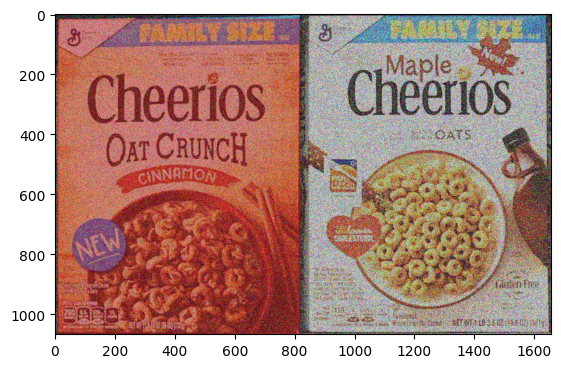

INFO:__main__:Matched density: 0.8868 * 1.0000 = 0.8868


Product 2 - Scene 1 - 1 instance found:
Instance 1 {position: (846, 8), width: 802px, height: 1049px}


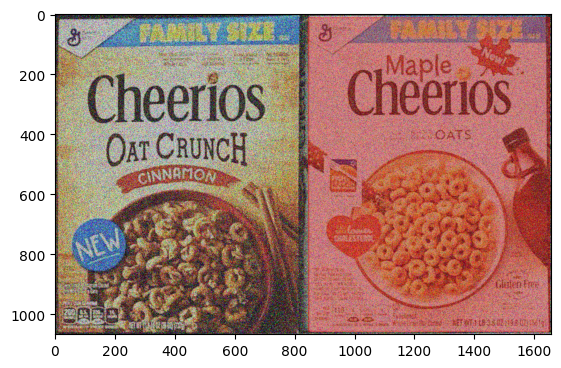

INFO:__main__:Product 3 - Scene 1 - No match found
INFO:__main__:Product 4 - Scene 1 - No match found
INFO:__main__:Product 5 - Scene 1 - No match found
INFO:__main__:Product 6 - Scene 1 - No match found
INFO:__main__:Product 7 - Scene 1 - No match found
INFO:__main__:Product 8 - Scene 1 - No match found
INFO:__main__:Product 9 - Scene 1 - No match found
INFO:__main__:Product 10 - Scene 1 - No match found
INFO:__main__:Product 11 - Scene 1 - No match found
INFO:__main__:Product 12 - Scene 1 - No match found
INFO:__main__:Product 13 - Scene 1 - No match found
INFO:__main__:Product 14 - Scene 1 - No match found
INFO:__main__:Product 1 - Scene 2 - No match found
INFO:__main__:Product 2 - Scene 2 - No match found
INFO:__main__:Matched density: 0.9091 * 1.0000 = 0.9091


Product 3 - Scene 2 - 1 instance found:
Instance 1 {position: (3, 23), width: 604px, height: 940px}


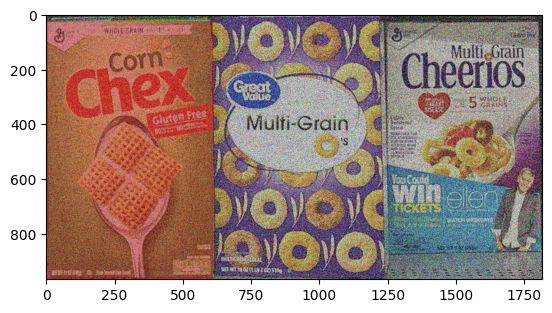

INFO:__main__:Matched density: 0.7843 * 1.0000 = 0.7843


Product 4 - Scene 2 - 1 instance found:
Instance 1 {position: (611, 7), width: 632px, height: 950px}


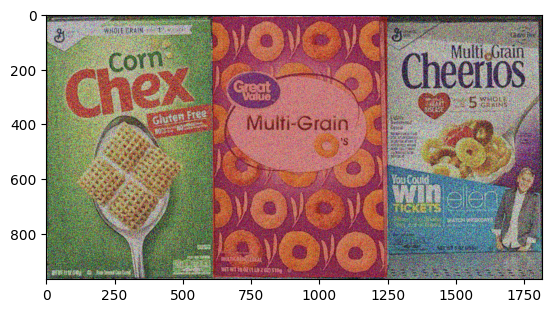

INFO:__main__:Matched density: 0.9111 * 1.0000 = 0.9111


Product 5 - Scene 2 - 1 instance found:
Instance 1 {position: (1247, 28), width: 561px, height: 843px}


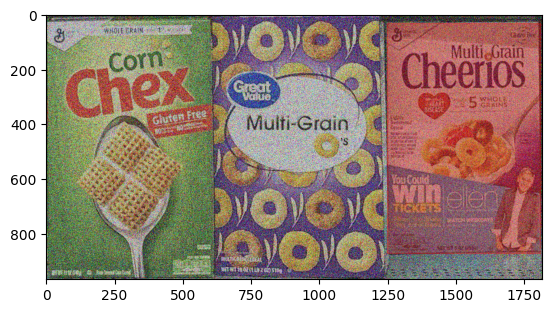

INFO:__main__:Product 6 - Scene 2 - No match found
INFO:__main__:Product 7 - Scene 2 - No match found
INFO:__main__:Product 8 - Scene 2 - No match found
INFO:__main__:Product 9 - Scene 2 - No match found
INFO:__main__:Matched density: 0.4815 * 1.0881 = 0.5239


Product 10 - Scene 2 - 1 instance found:
Instance 1 {position: (42, -58), width: 617px, height: 881px}


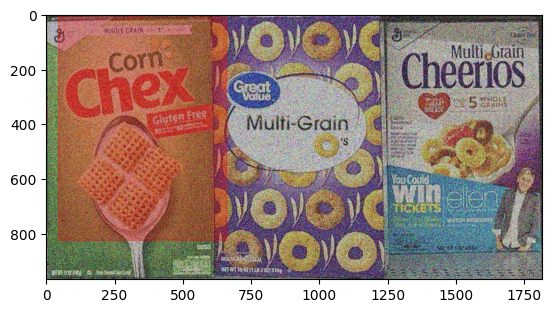

INFO:__main__:Product 11 - Scene 2 - No match found
INFO:__main__:Product 12 - Scene 2 - No match found
INFO:__main__:Product 13 - Scene 2 - No match found
INFO:__main__:Product 14 - Scene 2 - No match found
INFO:__main__:Product 1 - Scene 3 - No match found
INFO:__main__:Product 2 - Scene 3 - No match found
INFO:__main__:Product 3 - Scene 3 - No match found
INFO:__main__:Product 4 - Scene 3 - No match found
INFO:__main__:Product 5 - Scene 3 - No match found
INFO:__main__:Matched density: 0.8000 * 1.0038 = 0.8030


Product 6 - Scene 3 - 1 instance found:
Instance 1 {position: (-2, 122), width: 602px, height: 671px}


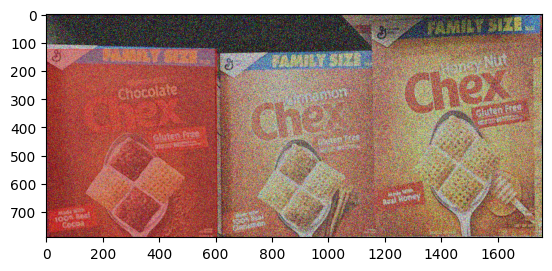

INFO:__main__:Matched density: 0.8000 * 1.0000 = 0.8000


Product 7 - Scene 3 - 1 instance found:
Instance 1 {position: (620, 135), width: 539px, height: 649px}


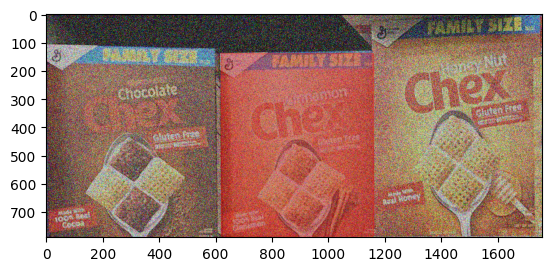

INFO:__main__:Matched density: 0.8000 * 1.0000 = 0.8000


Product 8 - Scene 3 - 1 instance found:
Instance 1 {position: (1167, 8), width: 559px, height: 779px}


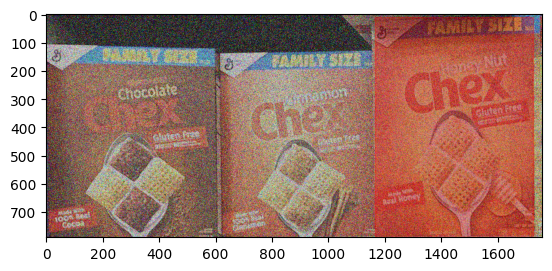

INFO:__main__:Product 9 - Scene 3 - No match found
INFO:__main__:Product 10 - Scene 3 - No match found
INFO:__main__:Product 11 - Scene 3 - No match found
INFO:__main__:Product 12 - Scene 3 - No match found
INFO:__main__:Product 13 - Scene 3 - No match found
INFO:__main__:Product 14 - Scene 3 - No match found
INFO:__main__:Matched density: 0.8444 * 1.0000 = 0.8444


Product 1 - Scene 4 - 1 instance found:
Instance 1 {position: (699, 660), width: 374px, height: 507px}


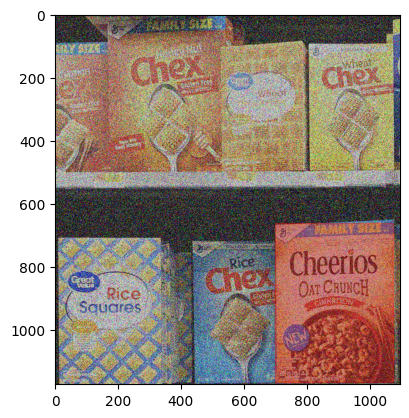

INFO:__main__:Product 2 - Scene 4 - No match found
INFO:__main__:Product 3 - Scene 4 - No match found
INFO:__main__:Product 4 - Scene 4 - No match found
INFO:__main__:Product 5 - Scene 4 - No match found
INFO:__main__:Product 6 - Scene 4 - No match found
INFO:__main__:Matched density: 0.4000 * 2.0773 = 0.8309


Product 7 - Scene 4 - 1 instance found:
Instance 1 {position: (-179, 95), width: 345px, height: 415px}


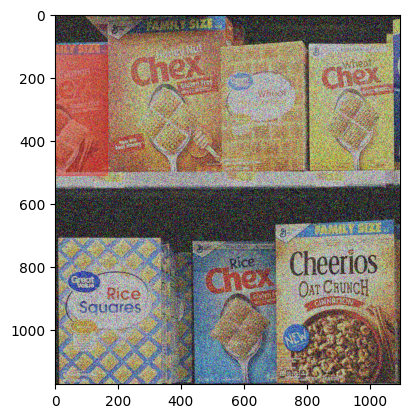

INFO:__main__:Matched density: 0.5600 * 1.0000 = 0.5600


Product 8 - Scene 4 - 1 instance found:
Instance 1 {position: (175, 14), width: 349px, height: 486px}


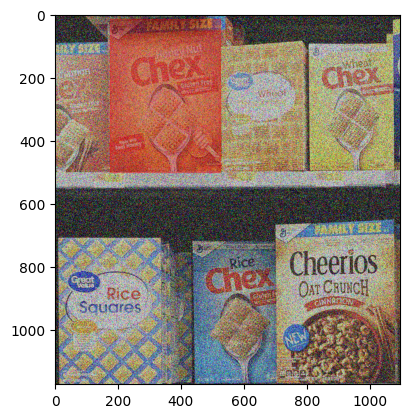

INFO:__main__:Matched density: 0.5263 * 1.0000 = 0.5263


Product 9 - Scene 4 - 1 instance found:
Instance 1 {position: (10, 711), width: 328px, height: 464px}


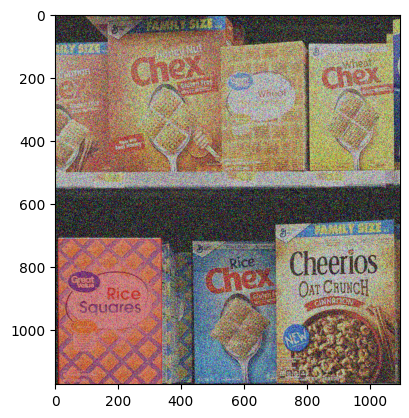

INFO:__main__:Matched density: 0.4074 * 1.0000 = 0.4074


Product 10 - Scene 4 - 1 instance found:
Instance 1 {position: (807, 93), width: 263px, height: 404px}


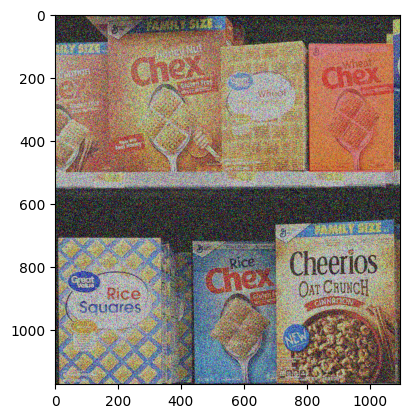

INFO:__main__:Product 11 - Scene 4 - No match found
INFO:__main__:Product 12 - Scene 4 - No match found
INFO:__main__:Product 13 - Scene 4 - No match found
INFO:__main__:Product 14 - Scene 4 - No match found
INFO:__main__:Product 1 - Scene 5 - No match found
INFO:__main__:Product 2 - Scene 5 - No match found
INFO:__main__:Product 3 - Scene 5 - No match found
INFO:__main__:Product 4 - Scene 5 - No match found
INFO:__main__:Product 5 - Scene 5 - No match found
INFO:__main__:Product 6 - Scene 5 - No match found
INFO:__main__:Product 7 - Scene 5 - No match found
INFO:__main__:Product 8 - Scene 5 - No match found
INFO:__main__:Product 9 - Scene 5 - No match found
INFO:__main__:Product 10 - Scene 5 - No match found
INFO:__main__:Matched density: 0.7273 * 1.0000 = 0.7273


Product 11 - Scene 5 - 1 instance found:
Instance 1 {position: (185, 476), width: 367px, height: 552px}


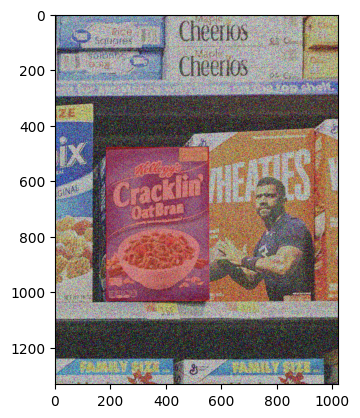

INFO:__main__:Matched density: 0.6250 * 1.0000 = 0.6250


Product 12 - Scene 5 - 1 instance found:
Instance 1 {position: (497, 418), width: 433px, height: 646px}


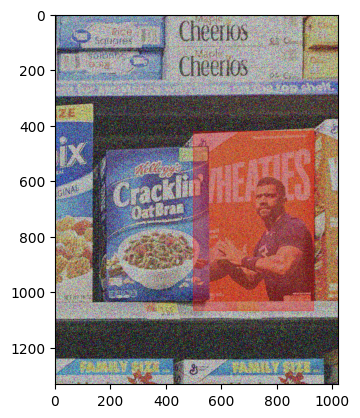

INFO:__main__:Product 13 - Scene 5 - No match found
INFO:__main__:Product 14 - Scene 5 - No match found
INFO:__main__:Correctness scene1: 2/2 (0 mistakes)
INFO:__main__:Correctness scene2: 3/3 (1 mistakes)
INFO:__main__:Correctness scene3: 3/3 (0 mistakes)
INFO:__main__:Correctness scene4: 5/5 (0 mistakes)
INFO:__main__:Correctness scene5: 2/2 (0 mistakes)


In [11]:
corrects = { idx: 0 for idx in SINGLE_INSTANCE_SCENE_IDXS }
mistakes = { idx: 0 for idx in SINGLE_INSTANCE_SCENE_IDXS }

for scene_idx, scene in zip(SINGLE_INSTANCE_SCENE_IDXS, single_instance_scenes):
    for template_idx, template in zip(SINGLE_INSTANCE_TEMPLATE_IDXS, single_instance_templates):
        template = single_instance_templates[template_idx-1]
        object_vertexes = singleInstanceDetection(scene.copy(), template)
        
        if object_vertexes is None: 
            logger.info(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue

        top_left, width, height = formatResultBox(object_vertexes)
        print(f"Product {template_idx} - Scene {scene_idx} - 1 instance found:")
        print("Instance 1 {{position: {position}, width: {width}px, height: {height}px}}".format(position=top_left, width=width, height=height))

        if template_idx in single_instance_ground_truth[scene_idx]: corrects[scene_idx] += 1
        else: mistakes[scene_idx] += 1

        if SHOW_PLOTS:
            plt.imshow(scene)
            plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=1, fill=True, alpha=0.3, color="r") )
            plt.show()
            print()

for scene_idx in SINGLE_INSTANCE_SCENE_IDXS:
    logger.info(f"Correctness scene{scene_idx}: {corrects[scene_idx]}/{len(single_instance_ground_truth[scene_idx])} ({mistakes[scene_idx]} mistakes)")

## Multiple instances detection

The multiple instances workflow is not very different from the single instance one. It is composed of the following steps:

1. Calculate SIFT keypoints in both scene and template images.
2. Identify candidate matches in the scene using k-nearest neighbors (KNN) search. It is very important to use the RANSAC method*.



* The RANSAC method is crucial because it enables the algorithm to 